# "1.4- NLP: Traducción automática y búsqueda de documentos"
> "Procesamiento del lenguaje natural con Clasificación y Espacios Vectoriales"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, NLP, ML]
- image: images/framework.jpg
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

Fuentes:
[DeepLearning.AI: Procesamiento de lenguaje natural. Programa especializado en Coursera](https://www.coursera.org/specializations/natural-language-processing) 

> tip: Puedes ver este post en GitHub o ejecutarlo en Binder o Google Colab, pulsa el icono.

# Transformar vectores de palabras
- Del lenguaje X to languaje Y -> X R =Y
- Aprender R:
- ![](images/nlp027.png)

![](images/nlp028.png)

# K-vecinos más próximos (KNN: K-nearest neighbors)
Necesitamos encontrar los vectores más similares a uno dado.

## Hashing
- **[hash_function](https://es.wikipedia.org/wiki/Funci%C3%B3n_hash)** = toma datos de tamaños arbitrarios y los asigna a un valor fijo.
- No hace falta compararlo con todos los ejemplos, simplemente con los valores en el mismo hash_bucket (cubo hash) al que se ha aplicado a la entrada el hash.

[+info](https://es.wikipedia.org/wiki/K_vecinos_m%C3%A1s_pr%C3%B3ximos)

![](images/nlp029.png)
![](images/nlp030.png)

In [10]:
def basic_hash_table(value_l, n_buckets):
    
    def hash_function(value, n_buckets):
        return int(value) % n_buckets
    
    hash_table = {i:[] for i in range(n_buckets)} # Initialize all the buckets in the hash table as empty lists

    for value in value_l:
        hash_value = hash_function(value,n_buckets) # Get the hash key for the given value
        hash_table[hash_value].append(value) # Add the element to the corresponding bucket
    
    return hash_table

In [9]:
value_l = [100, 10, 14, 17, 97] # Set of values to hash
hash_table_example = basic_hash_table(value_l, n_buckets=10)
pp.pprint(hash_table_example)

{   0: [100, 10],
    1: [],
    2: [],
    3: [],
    4: [14],
    5: [],
    6: [],
    7: [17, 97],
    8: [],
    9: []}


## hashing sensible a la localización
técnica que le permite hacer hash a entradas similares en los mismos cubos con alta probabilidad.

![](images/nlp031.png)

## Múltiples planos
para conseguir un único valor hash.

![](images/nlp032.png)

In [106]:
import numpy as np   # library for array and matrix manipulation
import pandas as pd
import pprint                     # utilities for console printing 
import matplotlib.pyplot as plt   # visualization library
pp = pprint.PrettyPrinter(indent=4) # Instantiate a pretty printer
import pdb
import pickle
import string
import time
#import gensim
import nltk
import scipy
import sklearn
import re
import string
#from gensim.models import KeyedVectors
from nltk.corpus import stopwords, twitter_samples
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from os import getcwd

In [66]:
# add folder, tmp2, from our local workspace containing pre-downloaded corpora files to nltk's data path
filePath = f"{getcwd()}/tmp2/"
nltk.data.path.append(filePath)

In [71]:
def get_dict(file_name):
    """
    This function returns the english to french dictionary given a file where the each column corresponds to a word.
    Check out the files this function takes in your workspace.
    """
    my_file = pd.read_csv(file_name, delimiter=' ')
    etof = {}  # the english to french dictionary to be returned
    for i in range(len(my_file)):
        # indexing into the rows.
        en = my_file.loc[i][0]
        fr = my_file.loc[i][1]
        etof[en] = fr

    return etof

In [72]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''
    # you have to set this variable to the true label.
    cos = -10
    dot = np.dot(A, B)
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)
    cos = dot / (norma * normb)

    return cos

In [64]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [65]:
# Procedure to plot and arrows that represents vectors with pyplot
def plot_vectors(vectors, colors=['k', 'b', 'r', 'm', 'c'], axes=None, fname='image.svg', ax=None):
    scale = 1
    scale_units = 'x'
    x_dir = []
    y_dir = []
    
    for i, vec in enumerate(vectors):
        x_dir.append(vec[0][0])
        y_dir.append(vec[0][1])
    
    if ax == None:
        fig, ax2 = plt.subplots()
    else:
        ax2 = ax
      
    if axes == None:
        x_axis = 2 + np.max(np.abs(x_dir))
        y_axis = 2 + np.max(np.abs(y_dir))
    else:
        x_axis = axes[0]
        y_axis = axes[1]
        
    ax2.axis([-x_axis, x_axis, -y_axis, y_axis])
        
    for i, vec in enumerate(vectors):
        ax2.arrow(0, 0, vec[0][0], vec[0][1], head_width=0.05 * x_axis, head_length=0.05 * y_axis, fc=colors[i], ec=colors[i])
    
    if ax == None:
        plt.show()
        fig.savefig(fname)


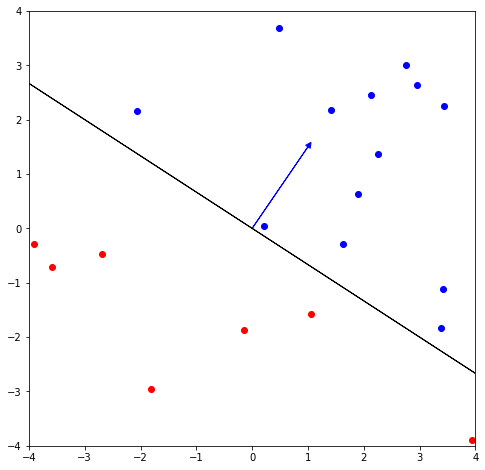

In [14]:
P = np.array([[1, 1.5]])  # Define a single plane. You may change the direction

# Get a new plane perpendicular to P. We use a rotation matrix
PT = np.dot([[0, 1], [-1, 0]], P.T).T  

fig, ax1 = plt.subplots(figsize=(8, 8)) # Create a plot with custom size

plot_vectors([P], colors=['b'], axes=[2, 2], ax=ax1) # Plot the plane P as a vector

# Plot the plane P as a 2 vectors. 
# We scale by 2 just to get the arrows outside the current box
plot_vectors([PT * 4, PT * -4], colors=['k', 'k'], axes=[4, 4], ax=ax1)

# Plot 20 random points. 
for i in range(0, 20):
        v1 = np.array(np.random.uniform(-4, 4, 2)) # Get a pair of random numbers between -4 and 4 
        side_of_plane = np.sign(np.dot(P, v1.T)) # Get the sign of the dot product with P
        # Color the points depending on the sign of the result of np.dot(P, point.T)
        if side_of_plane == 1:
            ax1.plot([v1[0]], [v1[1]], 'bo') # Plot a blue point
        else:
            ax1.plot([v1[0]], [v1[1]], 'ro') # Plot a red point

plt.show()

In [31]:
def side_of_plane_scalar(P, v):  # scalar
    dotproduct = np.dot(P, v.T) # Get the dot product P * v'
    sign_of_dot_product = np.sign(dotproduct) # The sign of the elements of the dotproduct matrix 
    sign_of_dot_product_scalar = sign_of_dot_product.item() # The value of the first item
    return sign_of_dot_product_scalar

In [32]:
def hash_multi_plane(P_l, v):
    hash_value = 0
    for i, P in enumerate(P_l):
        sign = side_of_plane_scalar(P,v)
        hash_i = 1 if sign >=0 else 0
        hash_value += 2**i * hash_i
    return hash_value

In [50]:
P1 = np.array([[1, 1]])   # First plane 2D
P2 = np.array([[-1, 1]])  # Second plane 2D
P3 = np.array([[-1, -1]]) # Third plane 2D
P_l = [P1, P2, P3]  # List of arrays. It is the multi plane

# Vector to search
v = np.array([[2,2]])

In [39]:
hash_multi_plane(P_l, v) # Find the number of the plane that containes this value

3

In [40]:
# Side of the plane function. The result is a matrix
def side_of_plane_matrix(P, v):
    dotproduct = np.dot(P, v.T)
    sign_of_dot_product = np.sign(dotproduct) # Get a boolean value telling if the value in the cell is positive or negative
    return sign_of_dot_product

## Planos aleatorios

In [57]:
np.random.seed(1)
num_dimensions = 2 # is 300 in assignment
num_planes = 3 # is 10 in assignment
random_planes_matrix = np.random.normal(
                       size=(num_planes,
                             num_dimensions))
print(random_planes_matrix)

[[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]
 [ 0.86540763 -2.3015387 ]]


In [58]:
sides_l = side_of_plane_matrix(random_planes_matrix, v)
sides_l

array([[ 1.],
       [-1.],
       [-1.]])

# Vecinos cercanos aproximados
Busca equilibrio entre precisión y eficiencia

# Traducción automática ingenua

## Los word embeddings para palabras en inglés y francés

In [69]:
en_embeddings_subset = pickle.load(open("./data/en_embeddings.p", "rb"))
fr_embeddings_subset = pickle.load(open("./data/fr_embeddings.p", "rb"))

In [74]:
# loading the english to french dictionaries
en_fr_train = get_dict('./data/en-fr.train.txt')
print('The length of the English to French training dictionary is', len(en_fr_train))
en_fr_test = get_dict('./data/en-fr.test.txt')
print('The length of the English to French test dictionary is', len(en_fr_test))

The length of the English to French training dictionary is 5000
The length of the English to French test dictionary is 1500


### Generar embedding y matrices de transformación

In [76]:
def get_matrices(en_fr, french_vecs, english_vecs):
    """
    Input:
        en_fr: English to French dictionary
        french_vecs: French words to their corresponding word embeddings.
        english_vecs: English words to their corresponding word embeddings.
    Output: 
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the projection matrix that minimizes the F norm ||X R -Y||^2.
    """    
    # X_l and Y_l are lists of the english and french word embeddings
    X_l = list()
    Y_l = list()    
    # get the english words (the keys in the dictionary) and store in a set()
    english_set = set(english_vecs.keys())  
    # get the french words (keys in the dictionary) and store in a set()
    french_set = set(french_vecs.keys())    
    # store the french words that are part of the english-french dictionary (these are the values of the dictionary)
    french_words = set(en_fr.values())
    
    # loop through all english, french word pairs in the english french dictionary
    for en_word, fr_word in en_fr.items():
        # check that the french word has an embedding and that the english word has an embedding
        if fr_word in french_set and en_word in english_set:
            # get the english embedding
            en_vec = english_vecs[en_word]
            # get the french embedding
            fr_vec = french_vecs[fr_word]
            # add the english embedding to the list
            X_l.append(en_vec)
            # add the french embedding to the list
            Y_l.append(fr_vec)
    # stack the vectors of X_l into a matrix X
    X = np.array(X_l)
    # stack the vectors of Y_l into a matrix Y
    Y = np.array(Y_l) 
    
    return X, Y

In [81]:
# getting the training set:
X_train, Y_train = get_matrices(
    en_fr_train, fr_embeddings_subset, en_embeddings_subset)

### Traducciones
#### Traduccion como transformación lineal de embeddings (R)
Encontrar una matriz R que minimice la siguiente ecuación:

![](images/nlp033.png)

In [83]:
def compute_loss(X, Y, R):
    '''
    Inputs: 
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)   
    # diff is XR - Y    
    diff = np.dot(X,R)-Y

    # diff_squared is the element-wise square of the difference    
    diff_squared = diff**2
    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = np.sum(diff_squared)

    # loss i the sum_diff_squard divided by the number of examples (m)
    loss = sum_diff_squared / m
    
    return loss

In [86]:
# Testing your implementation.
np.random.seed(123)
m = 10
n = 5
X = np.random.rand(m, n)
Y = np.random.rand(m, n) * .1
R = np.random.rand(n, n)
print(f"Expected loss for an experiment with random matrices: {compute_loss(X, Y, R):.4f}" ) 

Expected loss for an experiment with random matrices: 8.1866


### Cálculo del gradiente de la función de coste con respecto a la matriz de transformación R

![](images/nlp034.png)

In [87]:
def compute_gradient(X, Y, R):
    '''
    Inputs: 
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        g: a scalar value - gradient of the loss function L for given X, Y and R.
    '''   
    # m is the number of rows in X
    m = len(X)

    # gradient is X^T(XR - Y) * 2/m    
    gradient = np.dot(X.T,(np.dot(X,R)-Y))*2/m

    return gradient

In [90]:
# Testing your implementation.
np.random.seed(123)
m = 10
n = 5
X = np.random.rand(m, n)
Y = np.random.rand(m, n) * .1
R = np.random.rand(n, n)
gradient = compute_gradient(X, Y, R)
print(f"First row of the gradient matrix: {gradient[0]}")

First row of the gradient matrix: [1.3498175  1.11264981 0.69626762 0.98468499 1.33828969]


### Encontrar la R óptima con el algoritmo de descenso de gradiente
- Calcular el gradiente g de la función de coste con respecto a la matriz R .
- Actualice R con la fórmula: Rnew=Rold−αg , donde α es la tasa de aprendizaje, que es un escalar.

In [93]:
def align_embeddings(X, Y, train_steps=100, learning_rate=0.0003, verbose=True, compute_loss=compute_loss, compute_gradient=compute_gradient):
    '''
    Inputs:
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        train_steps: positive int - describes how many steps will gradient descent algorithm do.
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||X R -Y||^2
    '''
    np.random.seed(129)

    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])

    for i in range(train_steps):
        if verbose and i % 25 == 0:
            print(f"loss at iteration {i} is: {compute_loss(X, Y, R):.4f}")

        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X, Y, R)

        # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient

    return R

In [94]:
# Testing your implementation.
np.random.seed(129)
m = 10
n = 5
X = np.random.rand(m, n)
Y = np.random.rand(m, n) * .1
R = align_embeddings(X, Y)

loss at iteration 0 is: 3.7242
loss at iteration 25 is: 3.6283
loss at iteration 50 is: 3.5350
loss at iteration 75 is: 3.4442


### Calcular la matriz de transformación R

In [95]:
R_train = align_embeddings(X_train, Y_train, train_steps=400, learning_rate=0.8)

loss at iteration 0 is: 963.0146
loss at iteration 25 is: 97.8292
loss at iteration 50 is: 26.8329
loss at iteration 75 is: 9.7893
loss at iteration 100 is: 4.3776
loss at iteration 125 is: 2.3281
loss at iteration 150 is: 1.4480
loss at iteration 175 is: 1.0338
loss at iteration 200 is: 0.8251
loss at iteration 225 is: 0.7145
loss at iteration 250 is: 0.6534
loss at iteration 275 is: 0.6185
loss at iteration 300 is: 0.5981
loss at iteration 325 is: 0.5858
loss at iteration 350 is: 0.5782
loss at iteration 375 is: 0.5735


### Probando la traducción

#### Algoritmo k-vecinos más cercanos
- k-NN es un método que toma un vector como entrada y encuentra los otros vectores en el conjunto de datos que están más cerca de él.
- La 'k' es el número de "vecinos más cercanos" a encontrar (por ejemplo, k=2 encuentra los dos vecinos más cercanos).

#### Buscando la traducción del embedding
Dado que estamos aproximando la función de traducción de embeddings de inglés a francés mediante una matriz de transformación lineal R , la mayoría de las veces no obtendremos el embedding exacto de una palabra en francés.

Aquí es donde k-NN se vuelve realmente útil. Al usar 1-NN con eR como entrada, podemos buscar un  embedding f (como una fila) en la matriz Y que sea la más cercana al vector transformado eR

In [96]:
def nearest_neighbor(v, candidates, k=1, cosine_similarity=cosine_similarity):
    """
    Input:
      - v, the vector you are going find the nearest neighbor for
      - candidates: a set of vectors where we will find the neighbors
      - k: top k nearest neighbors to find
    Output:
      - k_idx: the indices of the top k closest vectors in sorted form
    """
    similarity_l = []

    # for each candidate vector...
    for row in candidates:
        # get the cosine similarity
        cos_similarity = np.dot(v,row)/(np.linalg.norm(v)*np.linalg.norm(row))
        
        # append the similarity to the list
        similarity_l.append(cos_similarity)

    # sort the similarity list and get the indices of the sorted list    
    sorted_ids = np.argsort(similarity_l)
    
    # Reverse the order of the sorted_ids array
    sorted_ids = sorted_ids[::-1]
    
    # get the indices of the k most similar candidate vectors
    k_idx = sorted_ids[:k]
    ### END CODE HERE ###
    return k_idx

In [97]:
# Test your implementation:
v = np.array([1, 0, 1])
candidates = np.array([[1, 0, 5], [-2, 5, 3], [2, 0, 1], [6, -9, 5], [9, 9, 9]])
print(candidates[nearest_neighbor(v, candidates, 3)])

[[2 0 1]
 [1 0 5]
 [9 9 9]]


#### Prueba la traducción y calcula su precisión
Precisión = total correctos / total

In [98]:
def test_vocabulary(X, Y, R, nearest_neighbor=nearest_neighbor):
    '''
    Input:
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the transform matrix which translates word embeddings from
        English to French word vector space.
    Output:
        accuracy: for the English to French capitals
    '''
    # The prediction is X times R
    pred = np.dot(X,R)    
    # initialize the number correct to zero
    num_correct = 0
    # loop through each row in pred (each transformed embedding)
    for i in range(len(pred)):
        # get the index of the nearest neighbor of pred at row 'i'; also pass in the candidates in Y
        pred_idx = nearest_neighbor(pred[i], Y, k=1, cosine_similarity=cosine_similarity)

        # if the index of the nearest neighbor equals the row of i... \
        if pred_idx == i:
            # increment the number correct by 1.
            num_correct += 1

    # accuracy is the number correct divided by the number of rows in 'pred' (also number of rows in X)
    accuracy = num_correct / len(pred)

    return accuracy

In [100]:
X_val, Y_val = get_matrices(en_fr_test, fr_embeddings_subset, en_embeddings_subset)
acc = test_vocabulary(X_val, Y_val, R_train)  # this might take a minute or two
print(f"accuracy on test set is {acc:.3f}")

accuracy on test set is 0.557


# LSH (locality sensitive hashing) y búsqueda de documentos

In [101]:
# get the positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
all_tweets = all_positive_tweets + all_negative_tweets

## Obtener los iembeddings de documentos
**Modelos de documento de bolsa de palabras (BOW)**: los documentos de texto son secuencias de palabras.

- El orden de las palabras marca la diferencia. Por ejemplo, las oraciones "La tarta de manzana es mejor que la pizza de pepperoni". y "La pizza de pepperoni es mejor que la tarta de manzana" tienen significados opuestos debido al orden de las palabras.
- Sin embargo, para algunas aplicaciones, ignorar el orden de las palabras puede permitirnos entrenar un modelo eficiente y efectivo. Este enfoque se denomina modelo de documento de bolsa de palabras.
**Embeddings de documentos**
- Los embeddings de documentos se crea sumando los embeddings de todas las palabras en el documento.
- Si no conocemos el embeddings de alguna palabra, podemos ignorar esa palabra.

In [102]:
def get_document_embedding(tweet, en_embeddings, process_tweet=process_tweet):
    '''
    Input:
        - tweet: a string
        - en_embeddings: a dictionary of word embeddings
    Output:
        - doc_embedding: sum of all word embeddings in the tweet
    '''
    doc_embedding = np.zeros(300)   
    # process the document into a list of words (process the tweet)
    processed_doc = process_tweet(tweet)
    for word in processed_doc:
        # add the word embedding to the running total for the document embedding        
        if word in en_embeddings.keys():
            doc_embedding += en_embeddings[word]

    return doc_embedding

In [107]:
# testing your function
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"
tweet_embedding = get_document_embedding(custom_tweet, en_embeddings_subset)
tweet_embedding[-5:]

array([-0.00268555, -0.15378189, -0.55761719, -0.07216644, -0.32263184])

## Almacene todos los vectores de documentos en un diccionario

In [108]:
def get_document_vecs(all_docs, en_embeddings, get_document_embedding=get_document_embedding):
    '''
    Input:
        - all_docs: list of strings - all tweets in our dataset.
        - en_embeddings: dictionary with words as the keys and their embeddings as the values.
    Output:
        - document_vec_matrix: matrix of tweet embeddings.
        - ind2Doc_dict: dictionary with indices of tweets in vecs as keys and their embeddings as the values.
    '''
    # the dictionary's key is an index (integer) that identifies a specific tweet
    # the value is the document embedding for that document
    ind2Doc_dict = {}

    # this is list that will store the document vectors
    document_vec_l = []

    for i, doc in enumerate(all_docs):

        # get the document embedding of the tweet
        doc_embedding = get_document_embedding(doc, en_embeddings, process_tweet=process_tweet)

        # save the document embedding into the ind2Tweet dictionary at index i
        ind2Doc_dict[i] = doc_embedding

        # append the document embedding to the list of document vectors
        document_vec_l.append(doc_embedding)

    # convert the list of document vectors into a 2D array (each row is a document vector)
    document_vec_matrix = np.vstack(document_vec_l)

    return document_vec_matrix, ind2Doc_dict

In [109]:
document_vecs, ind2Tweet = get_document_vecs(all_tweets, en_embeddings_subset)
print(f"length of dictionary {len(ind2Tweet)}")
print(f"shape of document_vecs {document_vecs.shape}")

length of dictionary 10000
shape of document_vecs (10000, 300)


## Buscando los tweets

In [110]:
my_tweet = 'i am sad'
process_tweet(my_tweet)
tweet_embedding = get_document_embedding(my_tweet, en_embeddings_subset)

In [111]:
# this gives you a similar tweet as your input.
# this implementation is vectorized...
idx = np.argmax(cosine_similarity(document_vecs, tweet_embedding))
print(all_tweets[idx])

@zoeeylim sad sad sad kid :( it's ok I help you watch the match HAHAHAHAHA


## Encontrar los tweets más similares con LSH
En lugar de mirar los 10.000 vectores, se puede buscar un subconjunto para encontrar sus vecinos más cercanos.

In [112]:
N_VECS = len(all_tweets)       # This many vectors.
N_DIMS = len(ind2Tweet[1])     # Vector dimensionality.
print(f"Number of vectors is {N_VECS} and each has {N_DIMS} dimensions.")
# The number of planes. We use log2(256) to have ~16 vectors/bucket.
N_PLANES = 10
# Number of times to repeat the hashing to improve the search.
N_UNIVERSES = 25

Number of vectors is 10000 and each has 300 dimensions.


## Elegir el número de planos
- Cada plano divide el espacio en 2 partes.
- Entonces n planos dividen el espacio en 2n cubos de hash.
- Queremos organizar 10,000 vectores de documentos en cubos para que cada cubo tenga alrededor de 16 vectores.
- Para eso necesitamos 10000/16=625 cubos.
- Nos interesa n , número de planos, por lo que 2n=625 . Ahora, podemos calcular n=log2 625=9.29≈10 .

## Obtener el número hash de un vector
Para cada vector, necesitamos obtener un número único asociado a ese vector para asignarlo a un "cubo de hash".

![](images/nlp035.png)

In [113]:
np.random.seed(0)
planes_l = [np.random.normal(size=(N_DIMS, N_PLANES))
            for _ in range(N_UNIVERSES)]

In [115]:
def hash_value_of_vector(v, planes):
    """Create a hash for a vector; hash_id says which random hash to use.
    Input:
        - v:  vector of tweet. It's dimension is (1, N_DIMS)
        - planes: matrix of dimension (N_DIMS, N_PLANES) - the set of planes that divide up the region
    Output:
        - res: a number which is used as a hash for your vector

    """
    # for the set of planes, calculate the dot product between the vector and the matrix containing the planes
    # remember that planes has shape (300, 10) The dot product will have the shape (1,10)    
    dot_product = np.dot(v,planes)
        
    # get the sign of the dot product (1,10) shaped vector
    sign_of_dot_product = np.sign(dot_product )
      
    # set h to be false (eqivalent to 0 when used in operations) if the sign is negative,
    # and true (equivalent to 1) if the sign is positive (1,10) shaped vector
    # if the sign is 0, i.e. the vector is in the plane, consider the sign to be positive  
    
    h= sign_of_dot_product >= 1     
    # remove extra un-used dimensions (convert this from a 2D to a 1D array)
    h = np.squeeze(h)       
    # initialize the hash value to 0
    hash_value = 0

    n_planes = len(planes[0])
    for i in range(n_planes):
        # increment the hash value by 2^i * h_i        
        hash_value += (2**i)* h[i]

    # cast hash_value as an integer
    hash_value = int(hash_value)

    return hash_value

In [116]:
np.random.seed(0)
idx = 0
planes = planes_l[idx]  # get one 'universe' of planes to test the function
vec = np.random.rand(1, 300)
print(f" The hash value for this vector,",
      f"and the set of planes at index {idx},",
      f"is {hash_value_of_vector(vec, planes)}")

 The hash value for this vector, and the set of planes at index 0, is 768


## Crear una tabla hash

In [117]:
def make_hash_table(vecs, planes, hash_value_of_vector=hash_value_of_vector):
    """
    Input:
        - vecs: list of vectors to be hashed.
        - planes: the matrix of planes in a single "universe", with shape (embedding dimensions, number of planes).
    Output:
        - hash_table: dictionary - keys are hashes, values are lists of vectors (hash buckets)
        - id_table: dictionary - keys are hashes, values are list of vectors id's
                            (it's used to know which tweet corresponds to the hashed vector)
    """
    # number of planes is the number of columns in the planes matrix
    num_of_planes = len(planes[0])

    # number of buckets is 2^(number of planes)    
    num_buckets = 2**num_of_planes

    # create the hash table as a dictionary.
    # Keys are integers (0,1,2.. number of buckets)
    # Values are empty lists
    hash_table = {i : [] for i in range(num_buckets)}
     
    # create the id table as a dictionary.
    # Keys are integers (0,1,2... number of buckets)
    # Values are empty lists
    id_table = {i : [] for i in range(num_buckets)}  
    
    # for each vector in 'vecs'
    for i, v in enumerate(vecs):           
        
        # calculate the hash value for the vector
        h = hash_value_of_vector(v, planes)
       
        # store the vector into hash_table at key h,
        # by appending the vector v to the list at key h
        hash_table[h].append(v)
        
        # store the vector's index 'i' (each document is given a unique integer 0,1,2...)
        # the key is the h, and the 'i' is appended to the list at key h
        id_table[h].append(i)

    return hash_table, id_table

In [118]:
planes = planes_l[0]  # get one 'universe' of planes to test the function
tmp_hash_table, tmp_id_table = make_hash_table(document_vecs, planes)

print(f"The hash table at key 0 has {len(tmp_hash_table[0])} document vectors")
print(f"The id table at key 0 has {len(tmp_id_table[0])}")
print(f"The first 5 document indices stored at key 0 of are {tmp_id_table[0][0:5]}")

The hash table at key 0 has 1351 document vectors
The id table at key 0 has 1351
The first 5 document indices stored at key 0 of are [3, 8, 16, 18, 29]


## Crear todas las tablas hash
haga un hash de sus vectores y guárdelos en una tabla hash que le permita buscar rápidamente y buscar vectores similares.

In [120]:
def create_hash_id_tables(n_universes):
    hash_tables = []
    id_tables = []
    for universe_id in range(n_universes):  # there are 25 hashes
        print('working on hash universe #:', universe_id)
        planes = planes_l[universe_id]
        hash_table, id_table = make_hash_table(document_vecs, planes)
        hash_tables.append(hash_table)
        id_tables.append(id_table)
    
    return hash_tables, id_tables

hash_tables, id_tables = create_hash_id_tables(N_UNIVERSES)

working on hash universe #: 0
working on hash universe #: 1
working on hash universe #: 2
working on hash universe #: 3
working on hash universe #: 4
working on hash universe #: 5
working on hash universe #: 6
working on hash universe #: 7
working on hash universe #: 8
working on hash universe #: 9
working on hash universe #: 10
working on hash universe #: 11
working on hash universe #: 12
working on hash universe #: 13
working on hash universe #: 14
working on hash universe #: 15
working on hash universe #: 16
working on hash universe #: 17
working on hash universe #: 18
working on hash universe #: 19
working on hash universe #: 20
working on hash universe #: 21
working on hash universe #: 22
working on hash universe #: 23
working on hash universe #: 24


## K-NN aproximado
usando hashing sensible a la localidad, para buscar documentos que sean similares a un documento dado en el índice doc_id

In [121]:
def approximate_knn(doc_id, v, planes_l, hash_tables, id_tables, k=1, num_universes_to_use=25, hash_value_of_vector=hash_value_of_vector):
    """Search for k-NN using hashes."""
    #assert num_universes_to_use <= N_UNIVERSES      
    vecs_to_consider_l = list()   # Vectors that will be checked as possible nearest neighbor 
    ids_to_consider_l = list()  # list of document IDs   
    ids_to_consider_set = set()  # create a set for ids to consider, for faster checking if a document ID already exists in the set

    # loop through the universes of planes
    for universe_id in range(num_universes_to_use):
        
        planes = planes_l[universe_id] # get the set of planes from the planes_l list, for this particular universe_id       
        hash_value = hash_value_of_vector(v, planes)  # get the hash value of the vector for this set of planes        
        hash_table = hash_tables[universe_id]  # get the hash table for this particular universe_id       
        document_vectors_l = hash_table[hash_value]   # get the list of document vectors for this hash table, where the key is the hash_value        
        id_table = id_tables[universe_id]  # get the id_table for this particular universe_id        
        new_ids_to_consider = id_table[hash_value] # get the subset of documents to consider as nearest neighbors from this id_table dictionary

        if doc_id in new_ids_to_consider:
            new_ids_to_consider.remove(doc_id)   #-----
            print(
                f"removed doc_id {doc_id} of input vector from new_ids_to_search")

        # loop through the subset of document vectors to consider
        for i, new_id in enumerate(new_ids_to_consider):

            # if the document ID is not yet in the set ids_to_consider...
            if new_id not in ids_to_consider_set:
                # access document_vectors_l list at index i to get the embedding
                # then append it to the list of vectors to consider as possible nearest neighbors
                document_vector_at_i = get_document_embedding(all_tweets[i], en_embeddings_subset, process_tweet=process_tweet)        #-----
                vecs_to_consider_l.append(document_vector_at_i)                  #-----

                # append the new_id (the index for the document) to the list of ids to consider
                ids_to_consider_l.append(new_id)

                # also add the new_id to the set of ids to consider
                # (use this to check if new_id is not already in the IDs to consider)
                ids_to_consider_set.add(new_id)

    # Now run k-NN on the smaller set of vecs-to-consider.
    print("Fast considering %d vecs" % len(vecs_to_consider_l))

    # convert the vecs to consider set to a list, then to a numpy array
    vecs_to_consider_arr = np.array(vecs_to_consider_l)

    # call nearest neighbors on the reduced list of candidate vectors
    nearest_neighbor_idx_l = nearest_neighbor(v, vecs_to_consider_arr, k=k)

    # Use the nearest neighbor index list as indices into the ids to consider
    # create a list of nearest neighbors by the document ids
    nearest_neighbor_ids = [ids_to_consider_l[idx]
                            for idx in nearest_neighbor_idx_l]

    return nearest_neighbor_ids

In [137]:
#document_vecs, ind2Tweet
doc_id = 5
doc_to_search = all_tweets[doc_id]
vec_to_search = document_vecs[doc_id]

In [138]:
nearest_neighbor_ids = approximate_knn(
    doc_id, vec_to_search, planes_l, hash_tables, id_tables, k=3, num_universes_to_use=5)

removed doc_id 5 of input vector from new_ids_to_search
removed doc_id 5 of input vector from new_ids_to_search
removed doc_id 5 of input vector from new_ids_to_search
removed doc_id 5 of input vector from new_ids_to_search
removed doc_id 5 of input vector from new_ids_to_search
Fast considering 150 vecs


C:\Users\juan_\AppData\Local\Temp/ipykernel_16868/2362656131.py:15: RuntimeWarning: invalid value encountered in double_scalars
  cos_similarity = np.dot(v,row)/(np.linalg.norm(v)*np.linalg.norm(row))


In [139]:
print(f"Nearest neighbors for document {doc_id}")
print(f"Document contents: {doc_to_search}")
print("")

for neighbor_id in nearest_neighbor_ids:
    print(f"Nearest neighbor at document id {neighbor_id}")
    print(f"document contents: {all_tweets[neighbor_id]}")

Nearest neighbors for document 5
Document contents: @BhaktisBanter @PallaviRuhail This one is irresistible :)
#FlipkartFashionFriday http://t.co/EbZ0L2VENM

Nearest neighbor at document id 4193
document contents: This girl :)  https://t.co/OAXMGGICNr
Nearest neighbor at document id 4045
document contents: @LemonyLimeUK thanks for the follow have a great day :)
Nearest neighbor at document id 8914
document contents: @zaynmalik zayn come back to 1D already. :(
